In [3]:
import os
import yfinance as yf
import quantstats as qs
import scipy.cluster.hierarchy as sch
import cvxopt as opt
import matplotlib.pyplot as plt
import shutil
import base64
import cvxpy as cp

from fredapi import Fred
from scipy.stats import spearmanr
from io import BytesIO
from datetime import timedelta
from IPython.display import Image
from tqdm import tqdm
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from sklearn.metrics import adjusted_mutual_info_score
from sklearn import cluster, covariance, manifold
from cvxopt import blas, solvers
from IPython.display import display
from scipy.optimize import minimize
from matplotlib.backends.backend_svg import FigureCanvasSVG

from class_model.model_prep import ModelPrep
from class_trend.trend_helper import TrendHelper
from core.system import *
from core.operation import *

import warnings

warnings.filterwarnings('ignore')

# Functions

In [2]:
#Reads in all the results in the "modelName" folder
def read_result(model_name, result_name):
    data = []
    result_data = get_ml_result_model(live, model_name)
    for i, folder_name in enumerate(os.listdir(result_data)):
        try:
            if folder_name.startswith("params"):
                folder_path = os.path.join(result_data, folder_name)
                file_path = os.path.join(folder_path, f"{result_name}.parquet.brotli")
                print(os.path.basename(folder_path))
                data.append(pd.read_parquet(file_path))
        except:
            continue
    return pd.concat(data, axis=0).reset_index(drop=True)

#Calculates the product of the daily_ic_mean and maximum overall IC in each result to find the best performing model
def get_max_ic(data):
    collection={}
    for index, row in data.iterrows():
        collection[max(row.loc[(row.index.str.startswith("daily_metric"))])]=index
    max_ic_idx=collection[max(list(collection.keys()))]
    return data.iloc[max_ic_idx]

#Gets the files of the best performing model
def get_max_ic_file(data, model_name):
    files = {}
    time_index = data.to_frame().index.get_loc('time')
    param_vals = data.iloc[:time_index].values
    key = [f'{float(p)}' for p in (param_vals)]
    key = '_'.join(key)
    
    result_data = get_ml_result_model(live, model_name) / f'params_{key}'
    for file in os.listdir(result_data):
        if file.endswith(".parquet.brotli"):
            files[extract_first_string(file)]=pd.read_parquet(os.path.join(result_data, file))
        elif file.endswith(".png"):
            img = os.path.join(result_data, file)
            files[extract_first_string(file)]=Image(img)
    return files

def get_all(model_name):
    return get_max_ic_file(get_max_ic(read_result(model_name, 'metrics')), model_name)

def sign_accuracy(predictions, actual, target_sign, pred):
    accuracies = []  # To store accuracies for each ticker
    
    # Iterate through each ticker and calculate accuracy
    for ticker in predictions.index.levels[0]:
        ticker_group = predictions.loc[ticker]
        actual_group = actual.loc[ticker]
        
        # Determine if each pair has the same sign
        if pred == 'price':
            correct_signs = (np.sign(ticker_group) == np.sign(actual_group))
        elif pred == 'sign':
            ticker_group = np.where(ticker_group > 0.5, 1, -1)
            correct_signs = (ticker_group == np.sign(actual_group))
            
        # Filter by target sign if specified
        if target_sign == 'positive':
            mask = (np.sign(actual_group) == 1)
            correct_signs = correct_signs[mask]
        elif target_sign == 'negative':
            mask = (np.sign(actual_group) == -1)
            correct_signs = correct_signs[mask]
        
        # Calculate the accuracy and store it
        accuracy = np.mean(correct_signs) * 100  # Convert to percentage
        accuracies.append(accuracy)
        
    # Calculate and return the mean accuracy across all tickers
    mean_accuracy = np.nanmean(accuracies)
    return mean_accuracy

In [116]:
def sharpe_ret(best_model_params, iteration):
    #Gets the predictions of the highest overall IC in the boosted round cases
    if iteration == False:
        best_prediction=best_model_params['predictions'][[str(extract_number(best_model_params['metrics'].loc[:, best_model_params['metrics'].columns.str.startswith("daily_metric")].idxmax(axis=1)[0])), 'i']]
    else:
        best_prediction=best_model_params['predictions'][[str(iteration), 'i']]
    actual_return=best_model_params['returns']
    #Merge actual returns and prediction returns
    merged = pd.merge(best_prediction, actual_return, left_index=True, right_index=True, how='left')
    merged.columns =['predictions', 'window', 'returns']
    merged.window = merged.window.astype(int)
    #Shift actual returns 1 day back
    merged['returns'] = merged.groupby('permno')['returns'].shift(-1)
    merged = merged.dropna()
    return merged

def sharpe_process_period(period, period_returns, num_stocks, candidates, threshold):
    # Find sp500 candidates for the given year and assign it to data
    period_year = period.index.get_level_values('date')[0].year

    # Filter the DataFrame to only include rows with market cap over the threshold
    filtered_period = period[period['market_cap'] > threshold]

    # Group by date and compute long and short stocks and their returns
    for date, stocks in filtered_period.groupby('date'):
        sorted_stocks = stocks.sort_values(by='predictions')
        long_stocks = sorted_stocks.index.get_level_values('permno')[-num_stocks:]
        short_stocks = sorted_stocks.index.get_level_values('permno')[:num_stocks]
        
        # Store results in period_returns DataFrame
        period_returns.loc[date] = [long_stocks.tolist(), sorted_stocks.iloc[-num_stocks:].returns.values,
                                    short_stocks.tolist(), sorted_stocks.iloc[:num_stocks].returns.values]


def sharpe_backtest(data, num_stocks, threshold):
    global live
    # Set portfolio weights and other tracking variables
    period_returns = pd.DataFrame(columns=['longStocks', 'longRet', 'shortStocks', 'shortRet'])
    
    # Get candidates
    candidates = get_candidate(live)
    
    # Loop over each group in tic.groupby('window')
    for _, df in tic.groupby('window'):
        df = df.reset_index().set_index(['permno', 'date']).drop('window', axis=1)
        sharpe_process_period(df, period_returns, num_stocks, candidates, threshold)
    
    return period_returns

# Read in Results

In [295]:
live = True
trial = 'randomforest_20240123'
files = read_result(trial, 'metrics')

params_50.0_6.0_2.0_1.0


In [296]:
keep = {}
ticker = pd.read_parquet(get_parquet(live) / 'data_ticker.parquet.brotli')
misc = pd.read_parquet(get_parquet(live) / 'data_misc.parquet.brotli', columns=['market_cap'])
for i, row in files.iterrows():
    read_file = get_max_ic_file(row, trial)
    returns = sharpe_ret(read_file, iteration=False)
    # Convert Permno to Ticker
    tic = returns.merge(ticker, left_index=True, right_index=True, how='left')
    tic = tic.merge(misc, left_index=True, right_index=True, how='left')
    tic = tic.reset_index().set_index(['window', 'permno', 'date'])
    pred = sharpe_backtest(tic, num_stocks=10, threshold=2_000_000_000)
    equal_weight = port_opt(data=pred, window_size=21, port_opt_func=ewp, option='both', leverage=0.5)
    stock = equal_weight['totalRet']
    sharpe = qs.stats.sharpe(stock)
    print('-' * 60)
    print(f'Row: {i}')
    display(read_file['metrics'])
    print(f'SHARPE Ratio: {sharpe}')
    keep[i] = sharpe
    break

------------------------------------------------------------
Row: 0


,n_estimators,max_depth,min_samples_split,min_samples_leaf,time,daily_metric_0
0,50.0,6.0,2.0,1.0,23166.313147,0.519884


SHARPE Ratio: 1.8849237753534973


[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  -----------
Start Period               2010-01-04   2010-01-04
End Period                 2024-01-19   2024-01-19
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          332.91%      40,971.62%
CAGR﹪                     7.47%        34.41%

Sharpe                     0.69         1.89
Prob. Sharpe Ratio         99.45%       100.0%
Smart Sharpe               0.69         1.88
Sortino                    0.96         2.61
Smart Sortino              0.96         2.6
Sortino/√2                 0.68         1.85
Smart Sortino/√2           0.68         1.84
Omega                      1.41         1.41

Max Drawdown               -34.1%       -32.69%
Longest DD Days            745          407
Volatility (ann.)          17.38%       24.38%
R^2                        0.0          0.0
Information Ratio          0.07         0.07
Calmar          

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-11-19,2020-06-05,2020-08-28,284,-32.694151,-28.875651
2,2013-11-14,2014-01-22,2014-05-13,181,-28.272860,-27.620634
3,2022-07-14,2023-02-01,2023-08-24,407,-25.190366,-23.330551
4,2018-10-12,2018-10-17,2018-12-17,67,-23.710140,-22.544700
5,2017-11-22,2018-03-15,2018-05-14,174,-23.492927,-22.674322


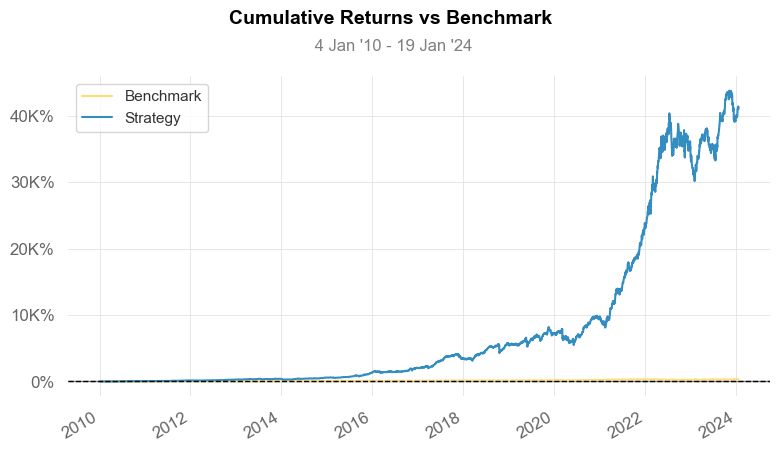

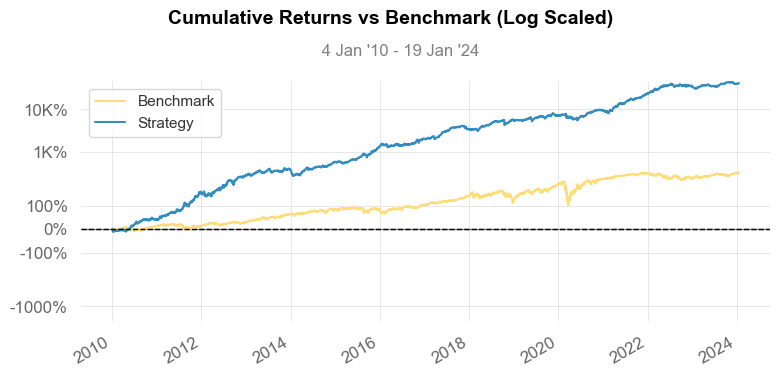

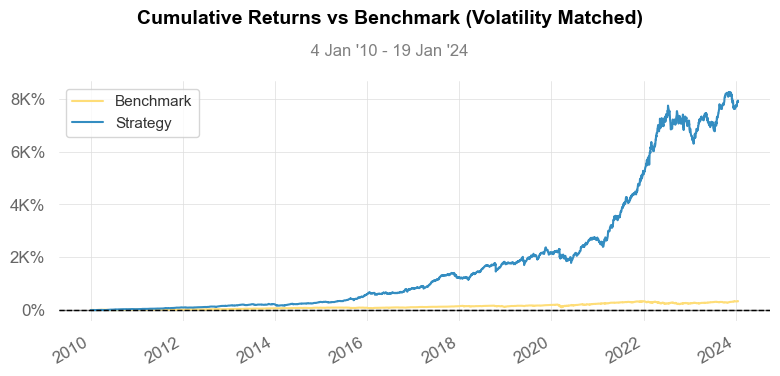

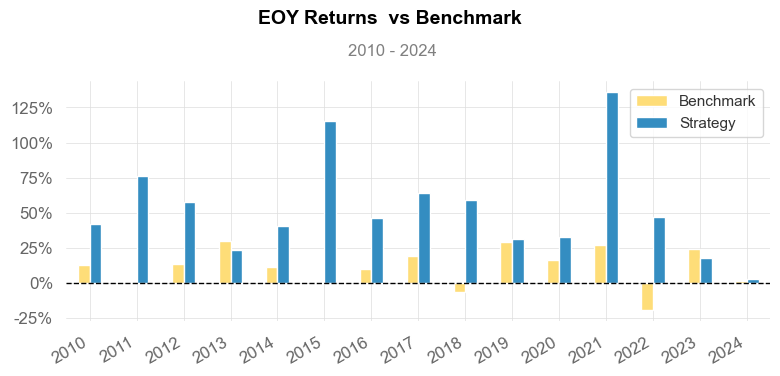

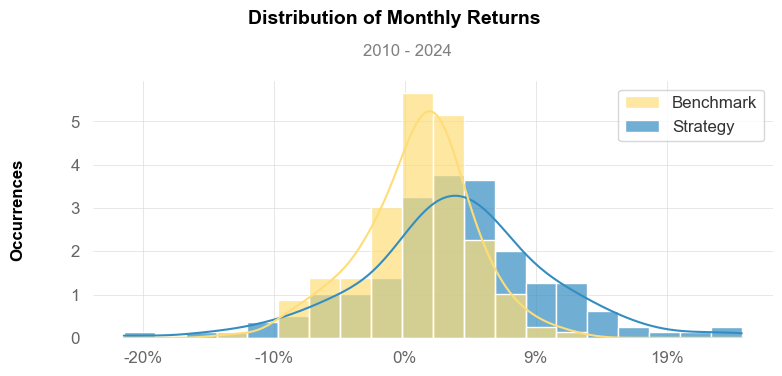

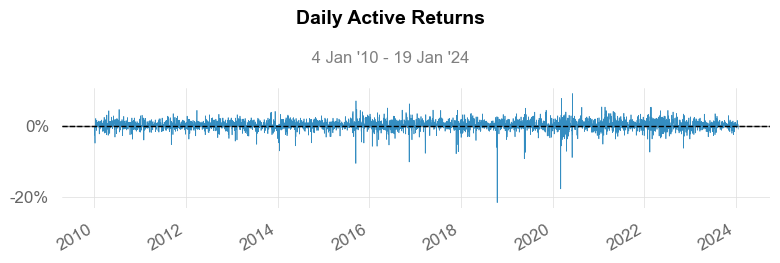

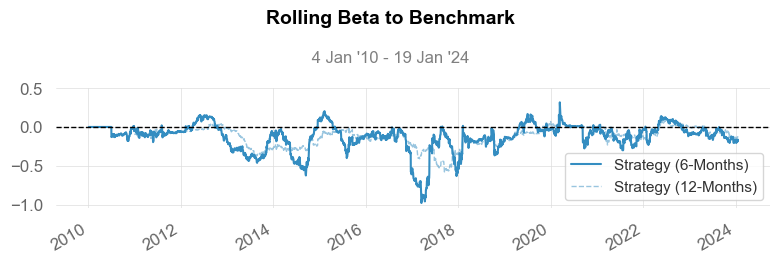

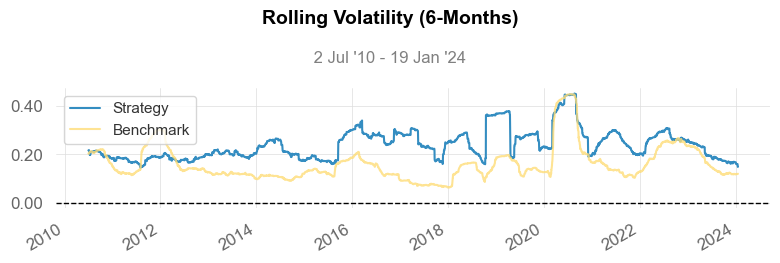

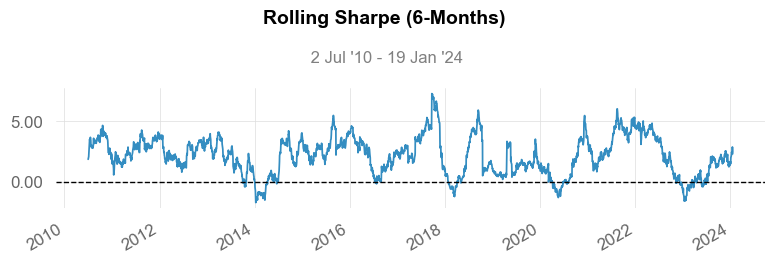

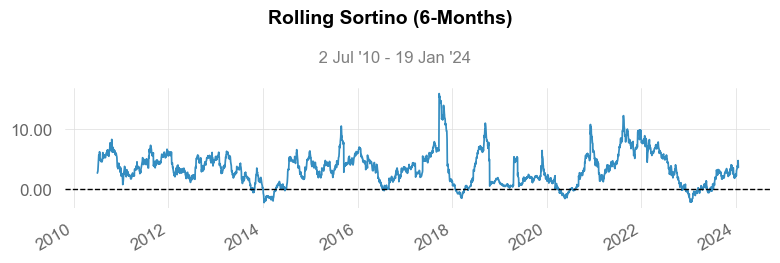

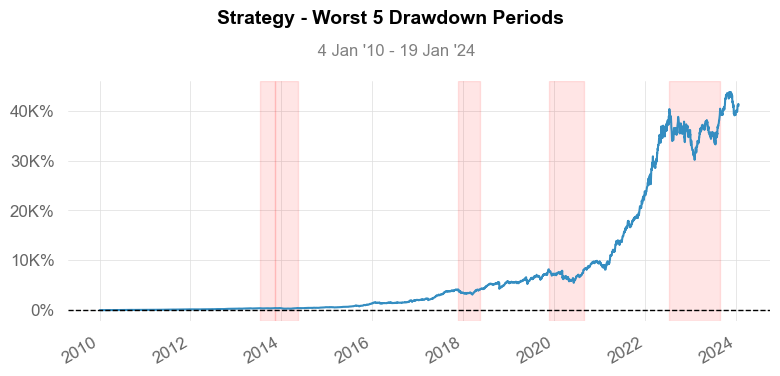

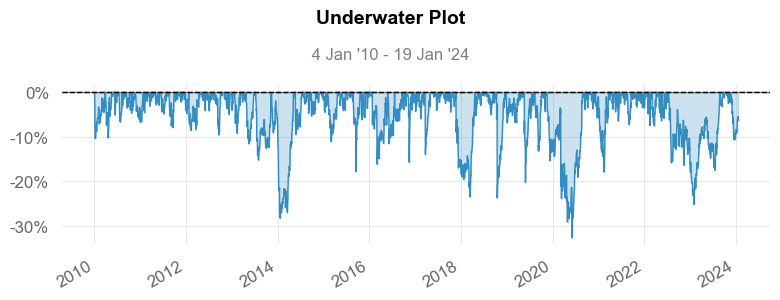

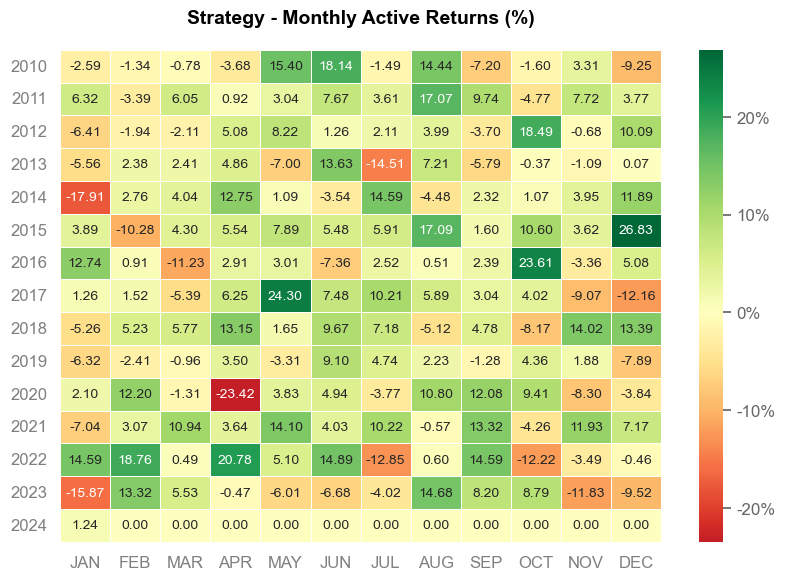

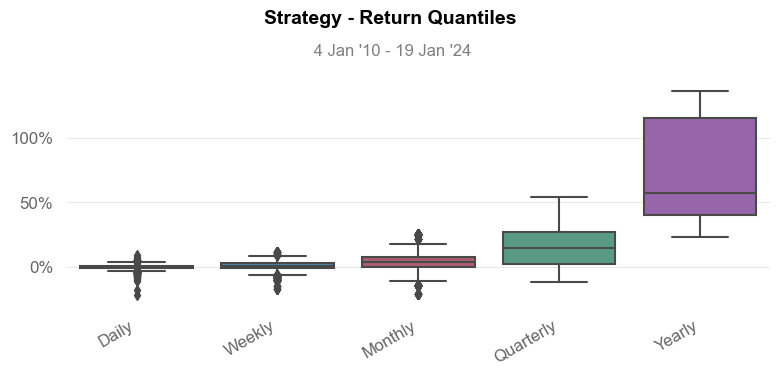

In [297]:
qs.reports.full(stock, 'SPY')

# Hedge against Bond Com

In [287]:
# Commodities
trend_helper = TrendHelper(current_date='2024-01-23', start_date='2005-01-01', num_stocks=50)
com_ticker = ['VNQ', 'IYR', 'SCHH', 'RWR', 'USRT', 'REZ']
com = trend_helper._get_ret(com_ticker)
# Bonds
bond_ticker = ['HYG', 'JNK', 'LQD', 'EMB', 'SHY', 'TLT', 'SPTL', 'IGSB', 'SPAB']
bond = trend_helper._get_ret(bond_ticker)

Fetching data: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:09<00:00,  1.00s/ticker]


In [288]:
# Create portfolio
bond_com_port = pd.concat([bond, com], axis=0)
bond_com_port['vol'] = bond_com_port.groupby('ticker')['RET_01'].transform(lambda x: x.rolling(5).std().shift(1))
bond_com_port['inv_vol'] = 1 / bond_com_port['vol']
bond_com_port['norm_inv_vol'] = bond_com_port.groupby('date')['inv_vol'].apply(lambda x: x / x.sum()).reset_index(level=0, drop=True)
bond_com_port['RET_01'] = bond_com_port['RET_01'].groupby('ticker').shift(-1)
bond_com_port['weighted_ret'] = bond_com_port['RET_01'] * bond_com_port['norm_inv_vol']
bond_com_port = bond_com_port.groupby('date')['weighted_ret'].sum()
bond_com_port = bond_com_port.to_frame()
bond_com_port.columns = ['bond_comm_ret']

# Date Index
date_index = bond_com_port.index
date_index = date_index.to_frame().drop('date', axis=1).reset_index()

In [289]:
with open(get_config() / 'api_key.json') as f:
    config = json.load(f)
    fred_key = config['fred_key']

# 5-Year Inflation Rate
fred = Fred(api_key=fred_key)
inflation = fred.get_series("T5YIE").to_frame()
inflation.columns = ['5YIF']
inflation = inflation.shift(1)
inflation = inflation.reset_index()
inflation = pd.merge_asof(date_index, inflation, left_on='date', right_on='index', direction='backward')
inflation = inflation.set_index('date').drop('index', axis=1)
inflation = inflation.ffill()

# 5-Year Market Yield
fred = Fred(api_key=fred_key)
unemploy = fred.get_series("DFII5").to_frame()
unemploy.columns = ['DF']
unemploy = unemploy.shift(1)
unemploy = unemploy.reset_index()
unemploy = pd.merge_asof(date_index, unemploy, left_on='date', right_on='index', direction='backward')
unemploy = unemploy.set_index('date').drop('index', axis=1)
unemploy = unemploy.ffill()

# 10-year vs. 2-year Yield Curve
fred = Fred(api_key=fred_key)
yield_curve = fred.get_series("T10Y2Y").to_frame()
yield_curve.columns = ['YIELD']
yield_curve = yield_curve.shift(1)
yield_curve = yield_curve.reset_index()
yield_curve = pd.merge_asof(date_index, yield_curve, left_on='date', right_on='index', direction='backward')
yield_curve = yield_curve.set_index('date').drop('index', axis=1)
yield_curve = yield_curve.ffill()

# Macro Trend
macro = pd.concat([inflation, unemploy, yield_curve], axis=1)
macro['5YIF_z'] = (macro['5YIF'] - macro['5YIF'].mean()) / macro['5YIF'].std()
macro['DF_z'] = (macro['DF'] - macro['DF'].mean()) / macro['DF'].std()
macro['YIELD_z'] = (macro['YIELD'] - macro['YIELD'].mean()) / macro['YIELD'].std()
macro['mt'] = macro[['5YIF_z', 'DF_z', 'YIELD_z']].mean(axis=1)

for t in [21, 60]:
    macro[f'mt_{t}'] = macro['mt'].rolling(t).mean()

macro_buy = (macro['mt_21'] > macro['mt_60'])
macro_buy_df = macro_buy.to_frame()
macro_buy_df.columns = ['macro_buy']

In [290]:
# Combine trend portfolio + hedge portfolio
total_ret = pd.merge(stock.to_frame('ml_trend'), bond_com_port, left_index=True, right_index=True, how='left')
total_ret = total_ret.merge(macro_buy_df, left_index=True, right_index=True, how='left')
col1, col2 = total_ret.columns[0], total_ret.columns[1]

def _calc_total_port(row, col1, col2):
    if row['macro_buy']:
        return 0.50 * row[col1] + 0.50 * row[col2]
    else:
        return 0.25 * row[col1] + 0.75 * row[col2]
        
total_ret['total_ret'] = total_ret.apply(_calc_total_port, args=(col1, col2), axis=1)
total_daily_ret = total_ret['total_ret']

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2010-01-04   2010-01-04
End Period                 2024-01-19   2024-01-19
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          332.91%      1,467.36%
CAGR﹪                     7.47%        14.48%

Sharpe                     0.69         2.01
Prob. Sharpe Ratio         99.45%       100.0%
Smart Sharpe               0.69         2.01
Sortino                    0.96         2.8
Smart Sortino              0.96         2.8
Sortino/√2                 0.68         1.98
Smart Sortino/√2           0.68         1.98
Omega                      1.46         1.46

Max Drawdown               -34.1%       -15.1%
Longest DD Days            745          366
Volatility (ann.)          17.38%       10.01%
R^2                        0.0          0.0
Information Ratio          0.03         0.03
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2019-11-19,2020-06-05,2020-08-19,275,-15.101142,-13.085170
2,2013-07-11,2014-01-22,2014-07-11,366,-14.455923,-13.717774
3,2018-10-12,2018-10-17,2019-01-18,99,-11.945009,-11.291036
4,2017-11-22,2018-03-15,2018-04-12,142,-10.108193,-9.736085
5,2020-12-09,2021-02-12,2021-03-19,101,-8.989074,-8.693212


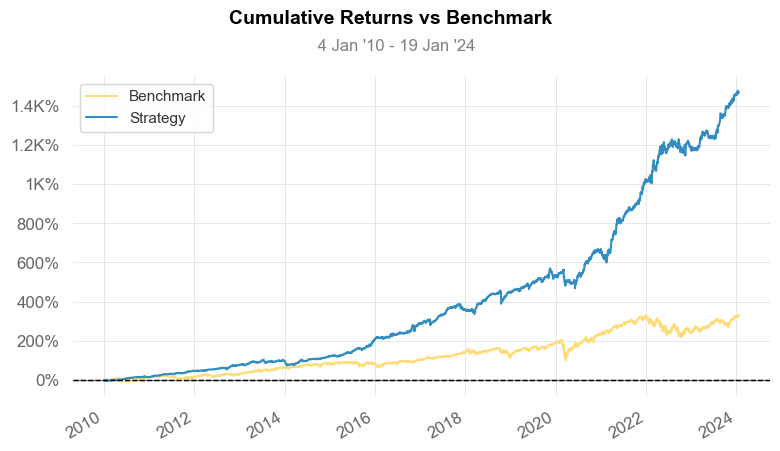

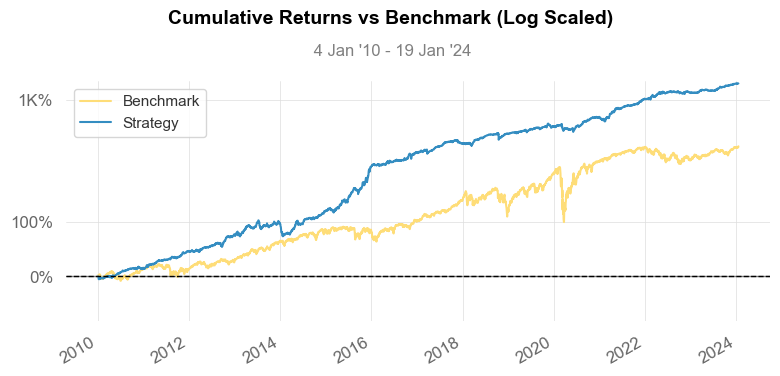

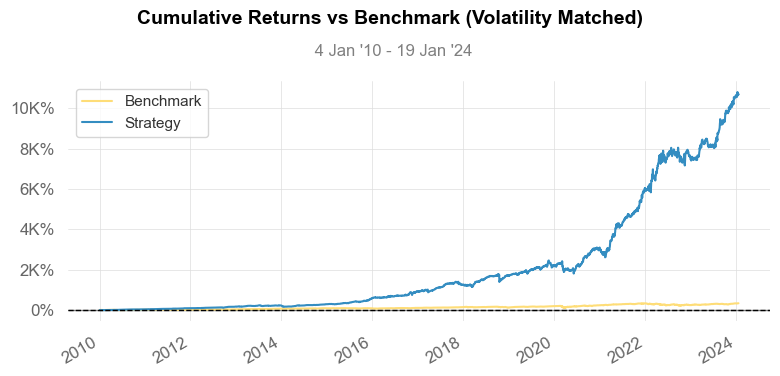

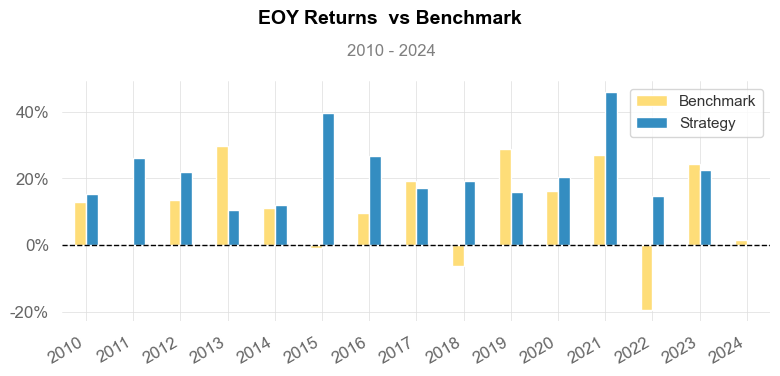

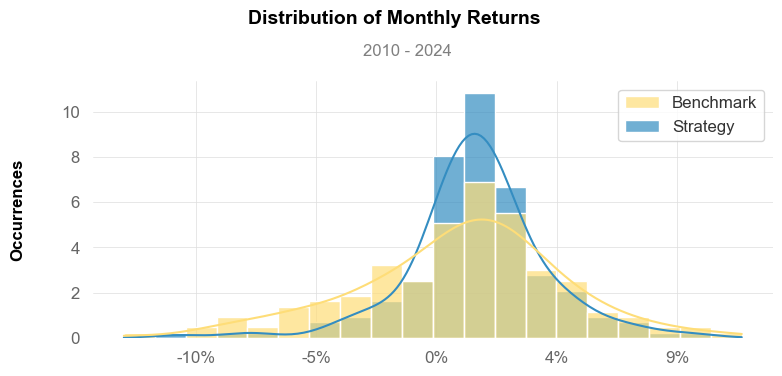

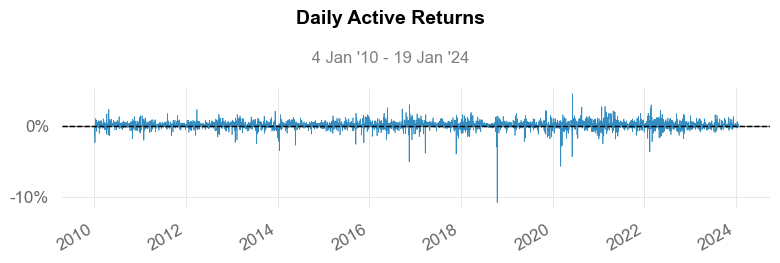

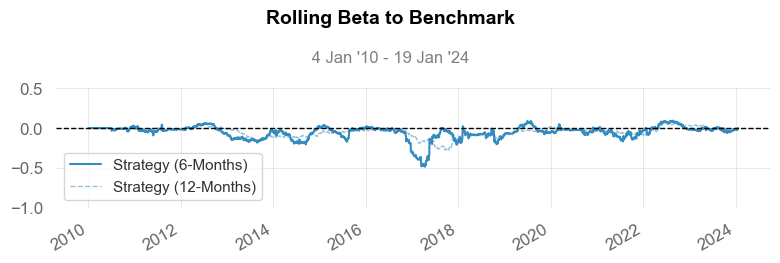

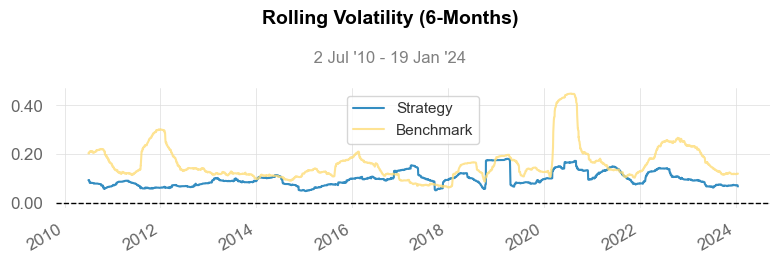

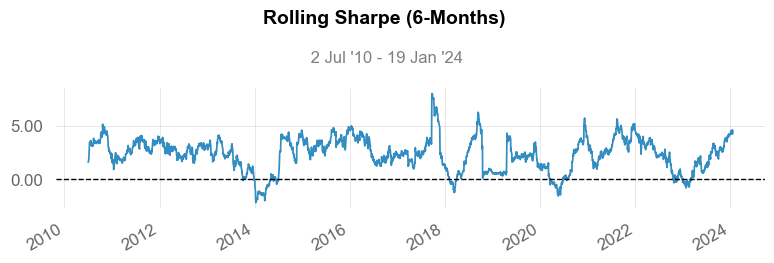

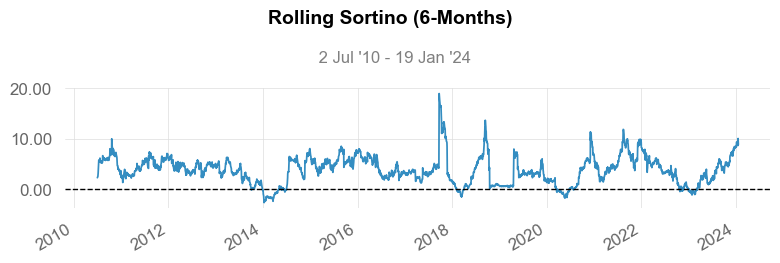

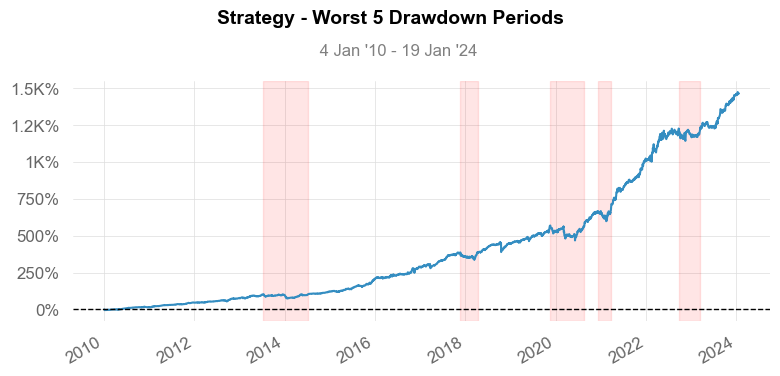

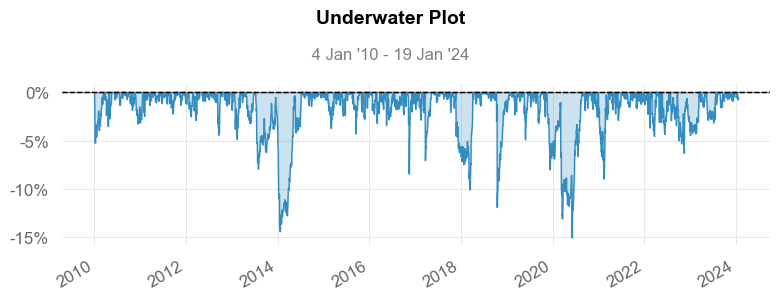

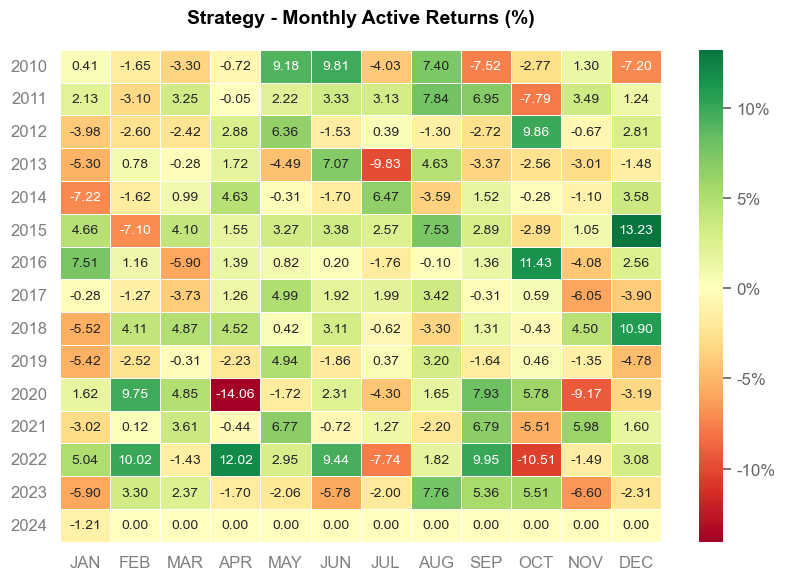

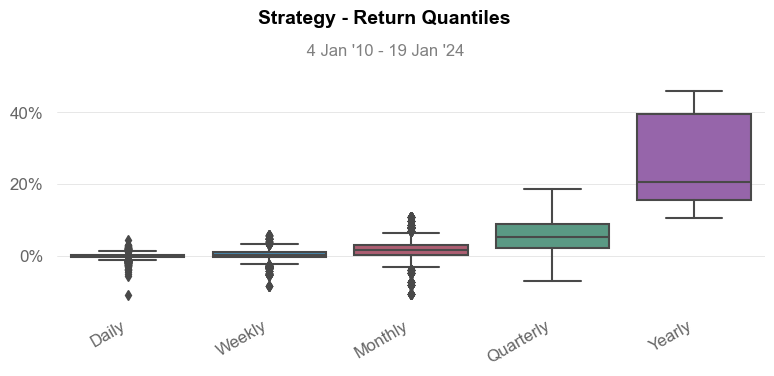

In [291]:
qs.reports.full(total_daily_ret, 'SPY')

# Minimizing Market Exposure

In [155]:
def mfl(data, stocks_to_use, col_name, exp, min_exp_weights, lambda_reg):
    def objective_cvxpy(weights, betas, min_exp_weights, lambda_reg):
        # Initialize the alternative objective
        factor_exposure  = 0.0
        # Loop through each factor and calculate its contribution to the objective
        for factor, weight in min_exp_weights.items():
            port_beta = cp.matmul(weights, betas[factor])
            factor_exposure += weight * cp.square(port_beta)
            
        l2_reg = cp.norm(weights, 2)**2
        return factor_exposure + lambda_reg * l2_reg

    collect_weight = []
    df_collect = []
    count = 0 
    print(f'Processing {type}...')
    for date, row in stocks_to_use.iterrows():
        stocks = stocks_to_use.loc[stocks_to_use.index == date][col_name][0]
        # Get betas for given stocks at day t
        betas = exp.loc[exp.index.get_level_values('date') == date]
        betas = get_stocks_data(betas, stocks)
        betas = betas.sort_index(level=['permno', 'date'])
        betas = betas.fillna(0)

        # CVXPY setup
        weights = cp.Variable(betas.shape[0])
        objective = cp.Minimize(objective_cvxpy(weights, betas, min_exp_weights, lambda_reg))
        constraints = [
            cp.sum(weights) == 1,
            weights >= 0.001,
            weights <= 0.10
        ]
        prob = cp.Problem(objective, constraints)
        prob.solve(solver='ECOS')
        collect_weight.append(weights.value)
        df_collect.append(betas.drop(betas.columns, axis=1))
        
        # Track performance
        if count % 30 == 0:
            print(date)
        count += 1

    # Create Dataframe
    save_df = pd.concat(df_collect, axis=0)
    # Flatten List
    flattened_array = np.concatenate(collect_weight).flatten()
    flattened_weight = flattened_array.tolist()
    # Add list to column
    save_df['exp_weight'] = flattened_weight
    return save_df

In [156]:
# Expected Return
returns['RET_01_expected'] = returns.groupby('permno')['returns'].shift(1)

In [157]:
stock = read_stock(get_large(live) / 'permno_live.csv')
start_date = pred.index.min().strftime("%Y-%m-%d")
end_date = pred.index.max().strftime("%Y-%m-%d")
sb_sector = ModelPrep(live=True, factor_name='factor_sb_sector', group='permno', interval='D', kind='price', stock=stock, div=False, start=start_date, end=end_date, save=False).prep()

Creating factor_sb_sector ---------------------------------- | ✔
Shape: (2744603, 32)


In [158]:
factor_col = ['XLB_RET_01_sector_01_126', 'XLE_RET_01_sector_01_126', 'XLF_RET_01_sector_01_126', 'XLI_RET_01_sector_01_126',
              'XLK_RET_01_sector_01_126', 'XLP_RET_01_sector_01_126', 'XLU_RET_01_sector_01_126', 'XLV_RET_01_sector_01_126',
              'XLY_RET_01_sector_01_126']
exp = sb_sector[factor_col]
min_exp_weights = {
    'XLB_RET_01_sector_01_126': 1,
    'XLE_RET_01_sector_01_126': 1,
    'XLF_RET_01_sector_01_126': 1,
    'XLI_RET_01_sector_01_126': 1,
    'XLK_RET_01_sector_01_126': 1,
    'XLP_RET_01_sector_01_126': 1,
    'XLU_RET_01_sector_01_126': 1,
    'XLV_RET_01_sector_01_126': 1,
    'XLY_RET_01_sector_01_126': 1
}
lambda_reg = 1

In [159]:
pred['totalStocks'] = pred.apply(lambda row: row['longStocks'] + row['shortStocks'], axis=1)

In [171]:
long_min_weights = mfl(data=returns, stocks_to_use=pred, col_name='longStocks', exp=exp, min_exp_weights=min_exp_weights, lambda_reg=lambda_reg)

Processing <class 'type'>...
2009-12-31 00:00:00
2010-02-16 00:00:00
2010-03-30 00:00:00
2010-05-12 00:00:00
2010-06-24 00:00:00
2010-08-06 00:00:00
2010-09-20 00:00:00
2010-11-01 00:00:00
2010-12-14 00:00:00
2011-01-27 00:00:00
2011-03-11 00:00:00
2011-04-25 00:00:00
2011-06-07 00:00:00
2011-07-20 00:00:00
2011-08-31 00:00:00
2011-10-13 00:00:00
2011-11-25 00:00:00
2012-01-10 00:00:00
2012-02-23 00:00:00
2012-04-05 00:00:00
2012-05-18 00:00:00
2012-07-02 00:00:00
2012-08-14 00:00:00
2012-09-26 00:00:00
2012-11-09 00:00:00
2012-12-24 00:00:00
2013-02-07 00:00:00
2013-03-22 00:00:00
2013-05-06 00:00:00
2013-06-18 00:00:00
2013-07-31 00:00:00
2013-09-12 00:00:00
2013-10-24 00:00:00
2013-12-06 00:00:00
2014-01-22 00:00:00
2014-03-06 00:00:00
2014-04-17 00:00:00
2014-06-02 00:00:00
2014-07-15 00:00:00
2014-08-26 00:00:00
2014-10-08 00:00:00
2014-11-19 00:00:00
2015-01-05 00:00:00
2015-02-18 00:00:00
2015-04-01 00:00:00
2015-05-14 00:00:00
2015-06-26 00:00:00
2015-08-10 00:00:00
2015-09-22 

In [172]:
short_min_weights = mfl(data=returns, stocks_to_use=pred, col_name='shortStocks', exp=exp, min_exp_weights=min_exp_weights, lambda_reg=lambda_reg)

Processing <class 'type'>...
2009-12-31 00:00:00
2010-02-16 00:00:00
2010-03-30 00:00:00
2010-05-12 00:00:00
2010-06-24 00:00:00
2010-08-06 00:00:00
2010-09-20 00:00:00
2010-11-01 00:00:00
2010-12-14 00:00:00
2011-01-27 00:00:00
2011-03-11 00:00:00
2011-04-25 00:00:00
2011-06-07 00:00:00
2011-07-20 00:00:00
2011-08-31 00:00:00
2011-10-13 00:00:00
2011-11-25 00:00:00
2012-01-10 00:00:00
2012-02-23 00:00:00
2012-04-05 00:00:00
2012-05-18 00:00:00
2012-07-02 00:00:00
2012-08-14 00:00:00
2012-09-26 00:00:00
2012-11-09 00:00:00
2012-12-24 00:00:00
2013-02-07 00:00:00
2013-03-22 00:00:00
2013-05-06 00:00:00
2013-06-18 00:00:00
2013-07-31 00:00:00
2013-09-12 00:00:00
2013-10-24 00:00:00
2013-12-06 00:00:00
2014-01-22 00:00:00
2014-03-06 00:00:00
2014-04-17 00:00:00
2014-06-02 00:00:00
2014-07-15 00:00:00
2014-08-26 00:00:00
2014-10-08 00:00:00
2014-11-19 00:00:00
2015-01-05 00:00:00
2015-02-18 00:00:00
2015-04-01 00:00:00
2015-05-14 00:00:00
2015-06-26 00:00:00
2015-08-10 00:00:00
2015-09-22 

In [160]:
all_min_weights = mfl(data=returns, stocks_to_use=pred, col_name='totalStocks', exp=exp, min_exp_weights=min_exp_weights, lambda_reg=lambda_reg)

Processing <class 'type'>...
2009-12-31 00:00:00
2010-02-16 00:00:00
2010-03-30 00:00:00
2010-05-12 00:00:00
2010-06-24 00:00:00
2010-08-06 00:00:00
2010-09-20 00:00:00
2010-11-01 00:00:00
2010-12-14 00:00:00
2011-01-27 00:00:00
2011-03-11 00:00:00
2011-04-25 00:00:00
2011-06-07 00:00:00
2011-07-20 00:00:00
2011-08-31 00:00:00
2011-10-13 00:00:00
2011-11-25 00:00:00
2012-01-10 00:00:00
2012-02-23 00:00:00
2012-04-05 00:00:00
2012-05-18 00:00:00
2012-07-02 00:00:00
2012-08-14 00:00:00
2012-09-26 00:00:00
2012-11-09 00:00:00
2012-12-24 00:00:00
2013-02-07 00:00:00
2013-03-22 00:00:00
2013-05-06 00:00:00
2013-06-18 00:00:00
2013-07-31 00:00:00
2013-09-12 00:00:00
2013-10-24 00:00:00
2013-12-06 00:00:00
2014-01-22 00:00:00
2014-03-06 00:00:00
2014-04-17 00:00:00
2014-06-02 00:00:00
2014-07-15 00:00:00
2014-08-26 00:00:00
2014-10-08 00:00:00
2014-11-19 00:00:00
2015-01-05 00:00:00
2015-02-18 00:00:00
2015-04-01 00:00:00
2015-05-14 00:00:00
2015-06-26 00:00:00
2015-08-10 00:00:00
2015-09-22 

### Calculate Portfolio Return

In [173]:
def set_exp_weight(data, weight, type):
    data = pd.merge(data, weight, left_index=True, right_index=True, how='left')
    if type == 'long':
        data['total_ret'] = data['returns'] * data['exp_weight'] * 1
    elif type == 'short':
        data['total_ret'] = data['returns'] * data['exp_weight'] * -1
    total_ret = data.groupby('date').total_ret.sum()
    return data, total_ret

In [174]:
def long_stock(group):
    date = group.index.get_level_values('date')[0]
    list = pred.loc[pred.index == date]['longStocks'][0]
    return get_stocks_data(group, list)

def short_stock(group):
    date = group.index.get_level_values('date')[0]
    list = pred.loc[pred.index == date]['shortStocks'][0]
    return get_stocks_data(group, list)

In [175]:
long_stocks = returns.groupby('date').apply(long_stock).reset_index(level=0, drop=True)
short_stocks = returns.groupby('date').apply(short_stock).reset_index(level=0, drop=True)

In [176]:
long_df, long_ret = set_exp_weight(data=long_stocks[['returns']], weight=long_min_weights, type='long')

In [177]:
short_df, short_ret = set_exp_weight(data=short_stocks[['returns']], weight=short_min_weights, type='short')

In [178]:
total_ret = 0.5 * long_ret + 0.5 * short_ret

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2010-01-04   2010-01-04
End Period                 2024-01-19   2024-01-19
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          332.91%      644.68%
CAGR﹪                     7.47%        10.37%

Sharpe                     0.69         1.4
Prob. Sharpe Ratio         99.45%       100.0%
Smart Sharpe               0.66         1.34
Sortino                    0.96         2.0
Smart Sortino              0.92         1.92
Sortino/√2                 0.68         1.41
Smart Sortino/√2           0.65         1.35
Omega                      1.28         1.28

Max Drawdown               -34.1%       -22.99%
Longest DD Days            745          705
Volatility (ann.)          17.38%       10.64%
R^2                        0.0          0.0
Information Ratio          0.01         0.01
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2012-12-28,2014-03-05,2014-12-02,705,-22.993085,-21.994669
2,2010-01-05,2010-04-26,2010-08-11,219,-14.536001,-13.464528
3,2015-08-27,2015-09-17,2015-10-22,57,-13.081398,-11.479972
4,2021-05-13,2022-03-17,2022-12-05,572,-11.894813,-10.675738
5,2011-12-29,2012-02-27,2012-07-17,202,-10.863504,-10.447218


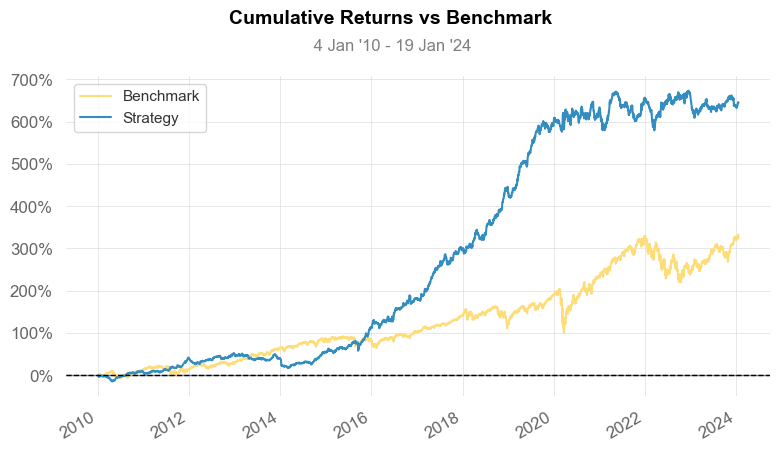

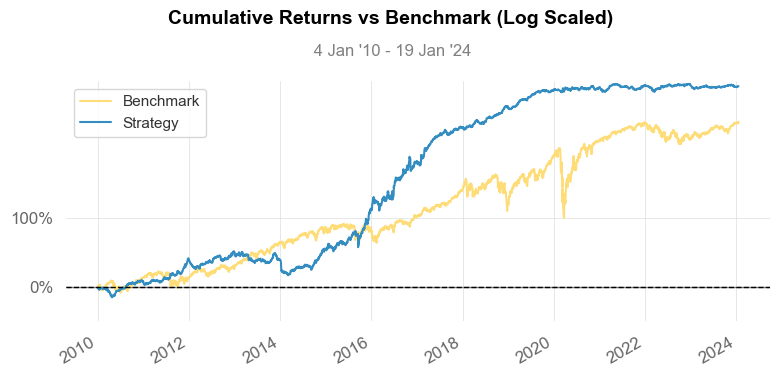

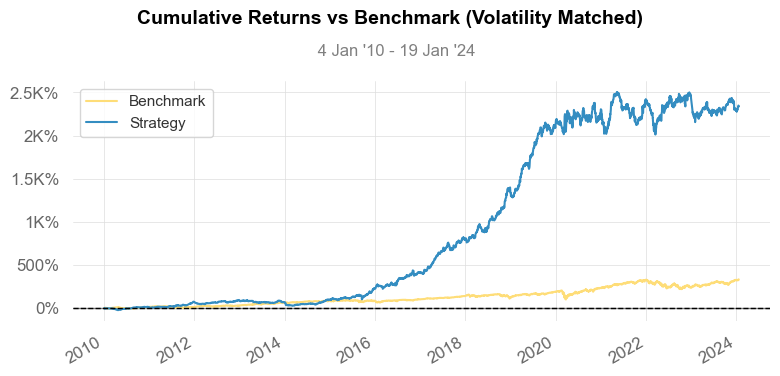

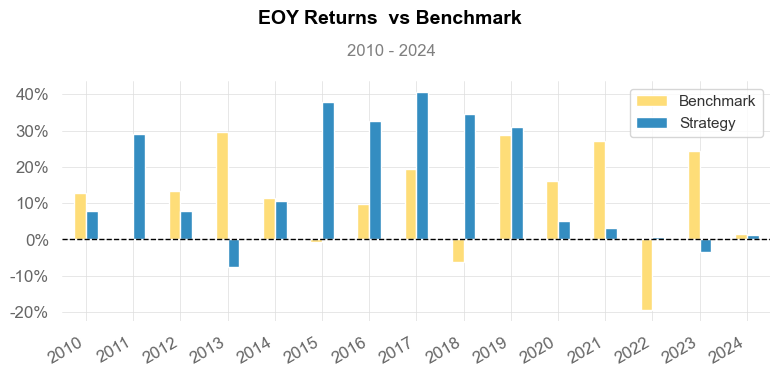

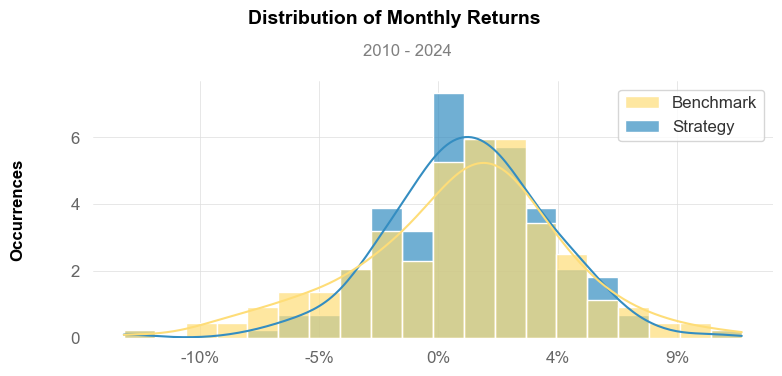

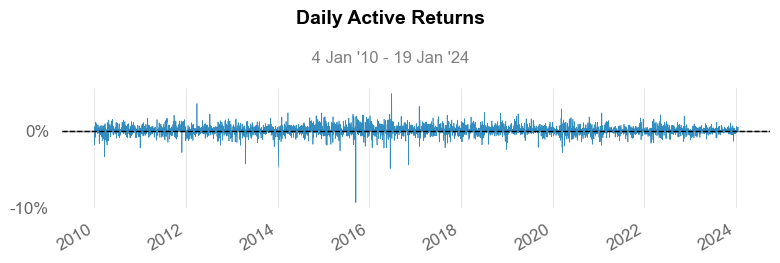

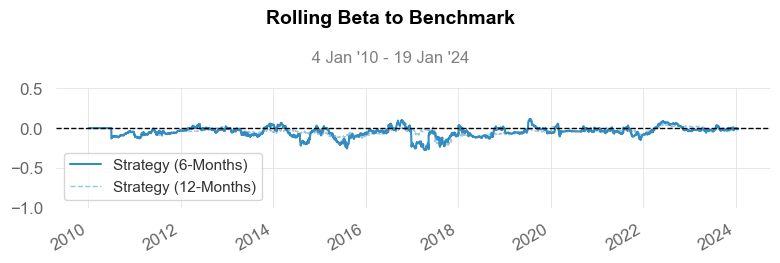

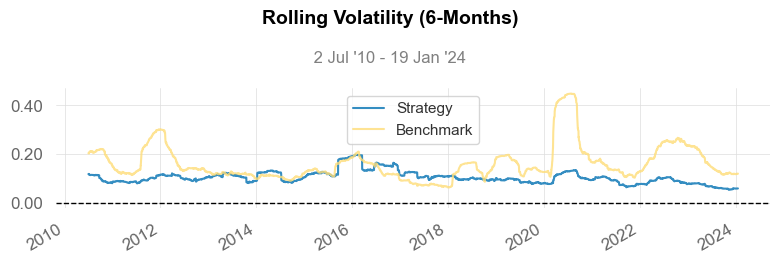

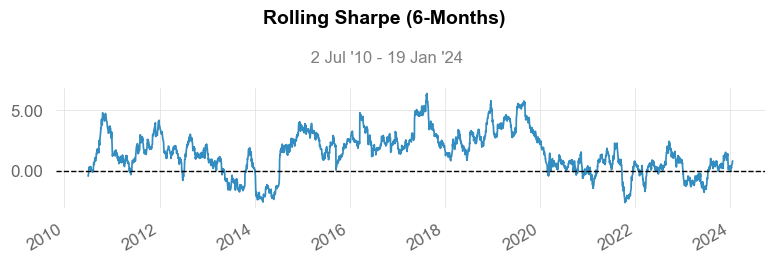

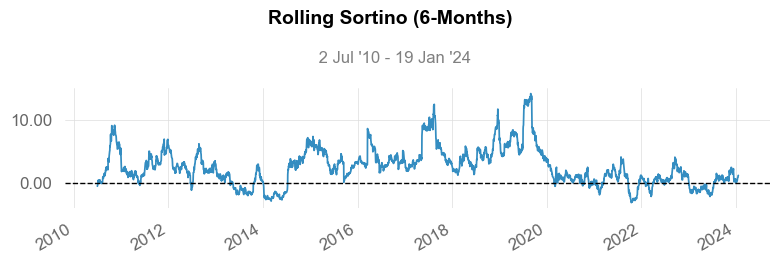

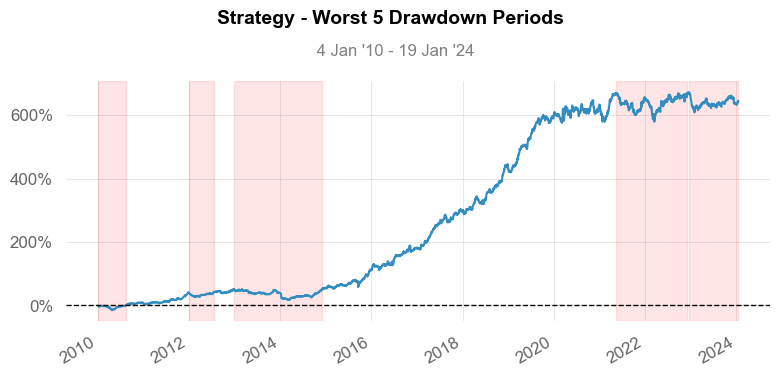

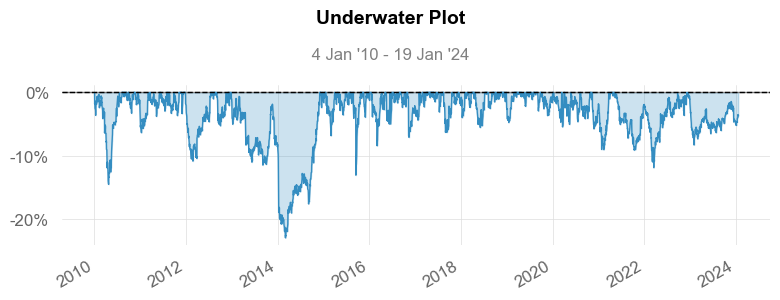

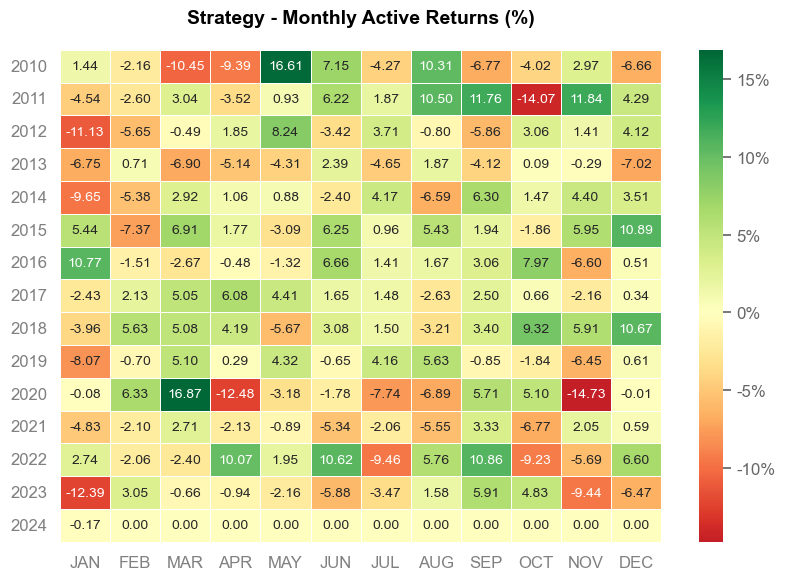

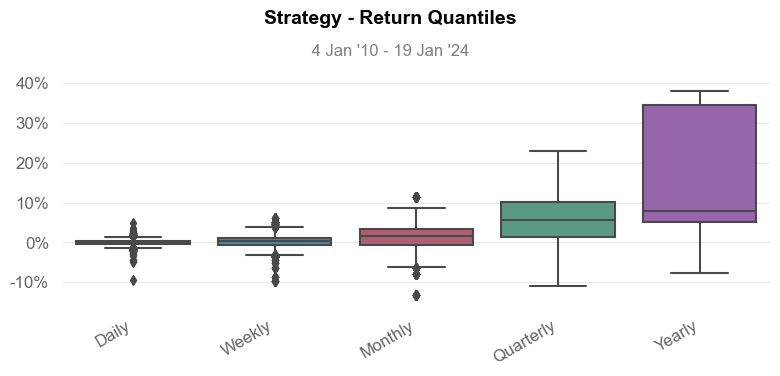

In [182]:
qs.reports.full(total_ret, 'SPY')

# Inverse Volatility

### Calculate Portfolio Return

In [183]:
vol_returns = returns.copy(deep=True)
vol_returns['accurate_returns'] = vol_returns.groupby('permno')['returns'].shift(1)
vol_returns['vol'] = vol_returns.groupby('permno')['accurate_returns'].transform(lambda x: x.rolling(5).std().shift(1))
vol_returns['inv_vol_weight'] = 1 / vol_returns['vol']

In [184]:
long_stocks = vol_returns.groupby('date').apply(long_stock).reset_index(level=0, drop=True)
short_stocks = vol_returns.groupby('date').apply(short_stock).reset_index(level=0, drop=True)

In [185]:
long_stocks['type'] = 1
short_stocks['type'] = -1

In [186]:
total_stocks = pd.concat([long_stocks, short_stocks], axis=0).sort_index(level=['permno', 'date'])

In [187]:
# Normalizing Weights
total_stocks['inv_vol_weight'] /= long_stocks.groupby('date')['inv_vol_weight'].transform(lambda x: x.abs().sum())

In [188]:
total_stocks['total_ret'] = total_stocks['returns'] * total_stocks['inv_vol_weight'] * total_stocks['type']

In [189]:
total_ret = total_stocks.groupby('date').total_ret.sum()

[*********************100%%**********************]  1 of 1 completed


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2010-01-11   2010-01-11
End Period                 2024-01-19   2024-01-19
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          321.08%      278.15%
CAGR﹪                     7.33%        6.76%

Sharpe                     0.68         0.64
Prob. Sharpe Ratio         99.39%       98.96%
Smart Sharpe               0.59         0.56
Sortino                    0.94         0.87
Smart Sortino              0.82         0.75
Sortino/√2                 0.67         0.61
Smart Sortino/√2           0.58         0.53
Omega                      1.13         1.13

Max Drawdown               -34.1%       -39.69%
Longest DD Days            745          746
Volatility (ann.)          17.38%       17.24%
R^2                        0.01         0.01
Information Ratio          -0.0         -0.0
Calmar             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-13,2020-03-20,2021-03-24,406,-39.690650,-36.333463
2,2022-01-04,2023-03-10,2024-01-19,746,-24.117306,-23.087598
3,2011-07-07,2011-08-05,2012-02-21,230,-16.814725,-15.201743
4,2018-09-21,2018-12-21,2019-02-13,146,-15.098280,-12.951491
5,2014-12-23,2015-08-24,2016-03-09,443,-12.257643,-10.754578


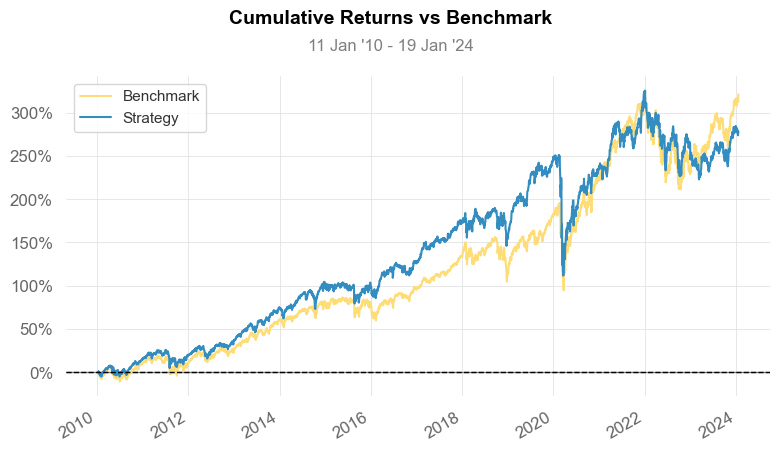

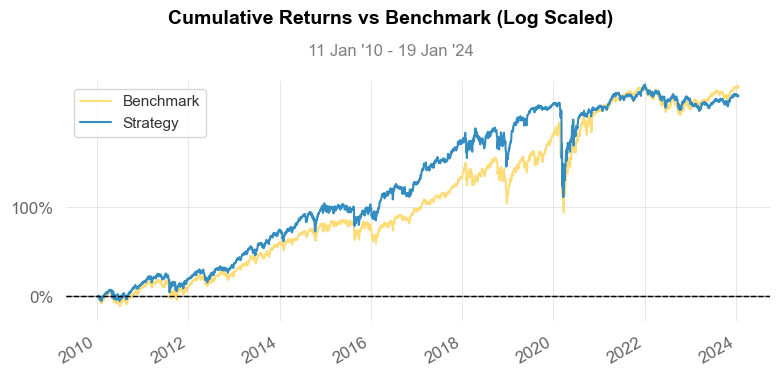

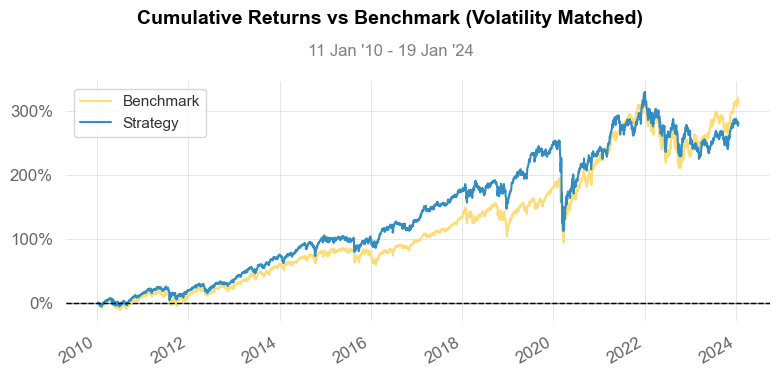

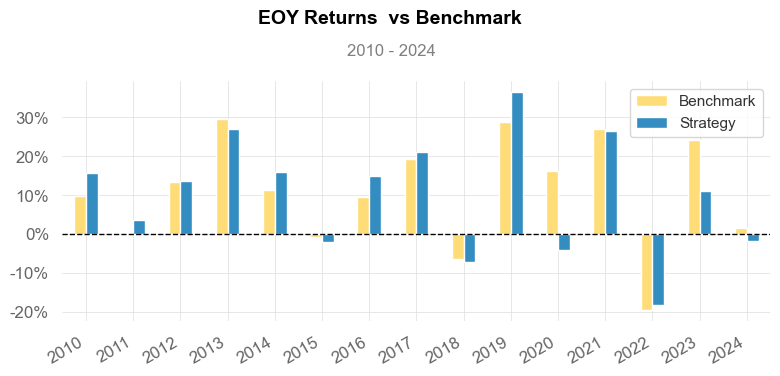

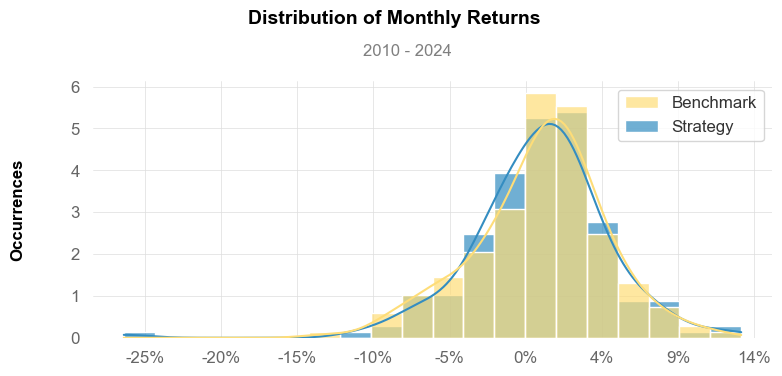

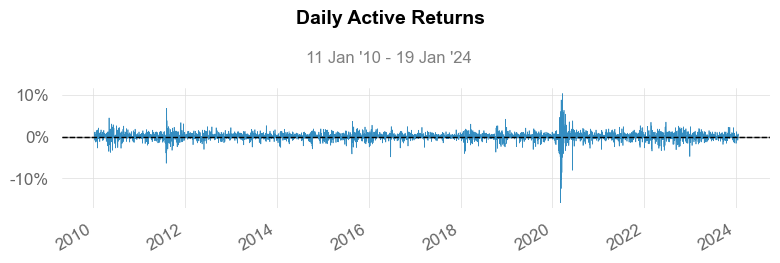

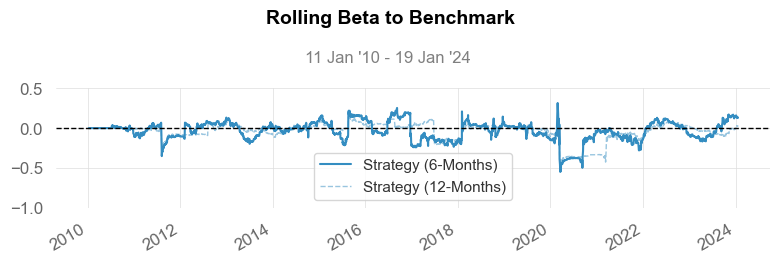

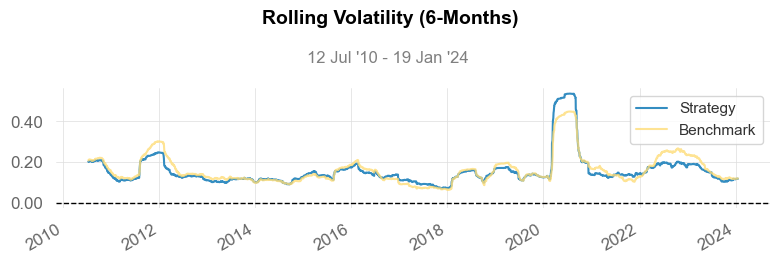

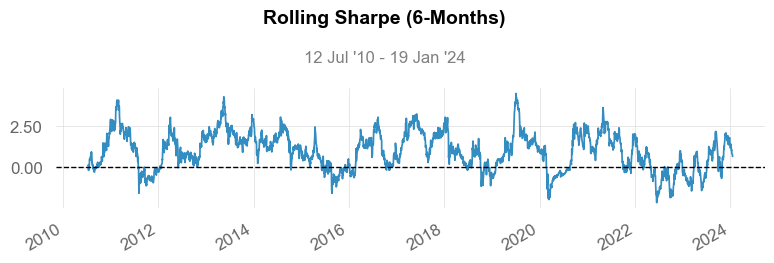

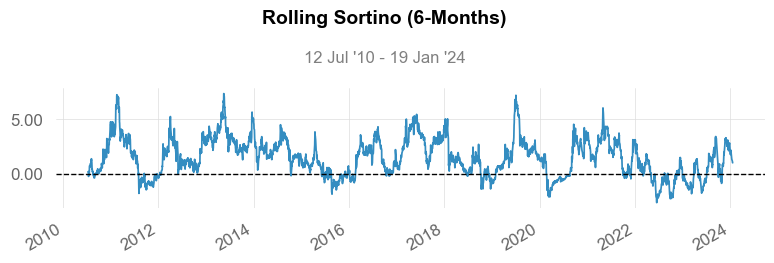

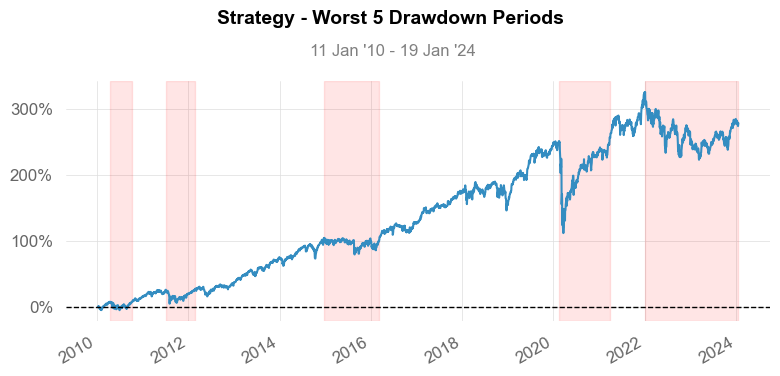

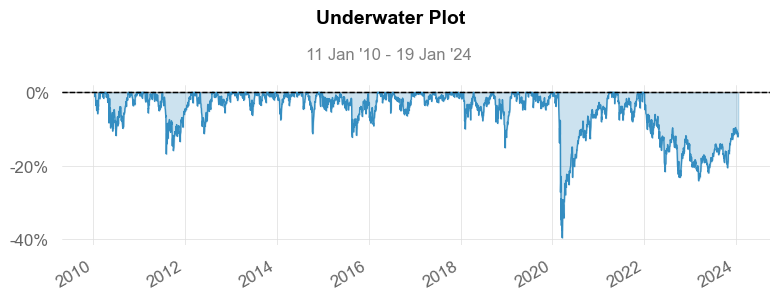

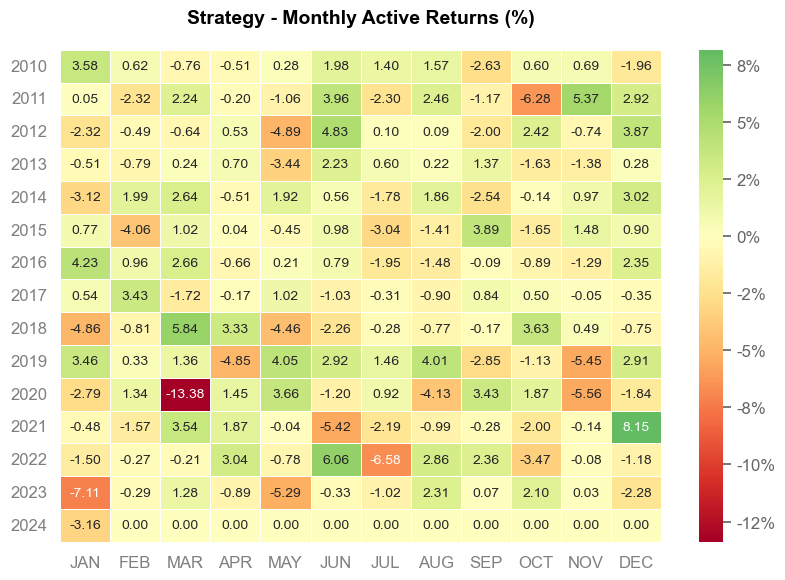

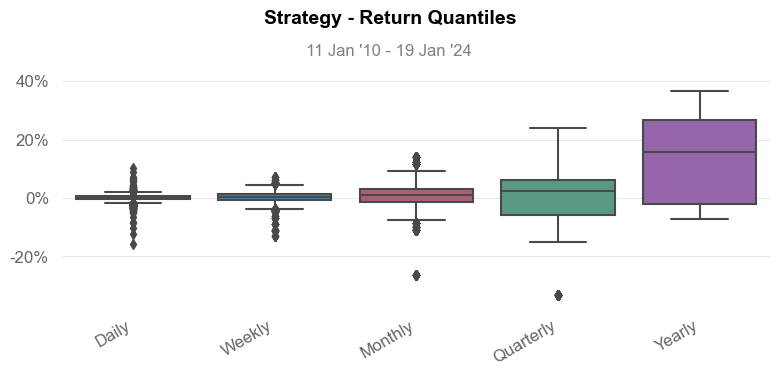

In [190]:
qs.reports.full(total_ret, 'SPY')